# Task9

Consider Bayesian linear regression. Restore covariance matrix using Bayesian optimization methods. The covariance rank matrix must vary from 1 to full-rank. Plot the dependence of the restoration performance from number of iterations for different ranks.

In [1]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00


## Solution
1. Creating synthetic dataset $y \sim Xw + ɛ$, $w \sim \mathcal{N}(0, \Sigma)$, $\text{rk}\Sigma = r$.

2. Find the best covariance matrix using Bayesian optimization.

In [10]:
import jax
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
import numpy as np
import matplotlib.pyplot as plt
import optuna



def run_optimization(rank):
    key = random.PRNGKey(0)
    N = 100  # number of objects
    D = 5  # dimention

    X = random.normal(key, (N, D))  # data

    A = np.random.normal(size=(D, rank))
    true_cov = A @ A.T  # covariance matrix
    true_weights = np.random.multivariate_normal(np.zeros(D,), true_cov)

    eps = 0.01 * random.normal(key, (N,))
    y = jnp.dot(X, true_weights) + eps  # target

    def loss(params):
        l = ((y - jnp.dot(X, params)) ** 2).sum()
        return l

    cov_diff_norm = []
    losses = []
    true_loss = loss(true_weights)

    def objective(trial):
        A = np.zeros((5, rank))  # suggest covariance matrix for bayesian optimization
        for i in range(5):
            for j in range(rank):
                A[i, j] = trial.suggest_float(f'{i}_{j}', -1, 1)

        cov = A @ A.T
        init_params = jnp.array(np.random.multivariate_normal(np.zeros(D,), cov))

        opt_init, opt_update, get_params = optimizers.sgd(1e-3)
        opt_state = opt_init(init_params)

        def step(step, opt_state):
            value, grads = jax.value_and_grad(loss)(get_params(opt_state))
            opt_state = opt_update(step, grads, opt_state)
            return value, opt_state

        num_steps = 250
        for i in range(num_steps):
            value, opt_state = step(i, opt_state)

        params = get_params(opt_state)
        cov_diff_norm.append(jnp.linalg.norm(cov - true_cov).item())

        l = loss(params)
        losses.append(l.item())
        return l

    def get_cov(params):
        # To restore optimal covariance matrix
        A = np.zeros((5, rank))
        for i in range(5):
            for j in range(rank):
                A[i, j] = params[f'{i}_{j}']
        cov_hat = A @ A.T

        return jnp.linalg.norm(cov_hat - true_cov)


    study = optuna.create_study(direction='minimize')
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials=50)

    optimal_params = study.best_trial.params
    best_loss_diff = get_cov(optimal_params)

    return cov_diff_norm, losses, true_loss, best_loss_diff

## Collect restoration data

In [11]:
res = {}
for rank in [1, 2, 3, 4, 5]:
    res[rank] = run_optimization(rank)

## Plot results

Norm difference for best regression loss
rank=1, norm diff: 3.7598433
rank=2, norm diff: 2.4925258
rank=3, norm diff: 10.387081
rank=4, norm diff: 7.6329722
rank=5, norm diff: 11.114021


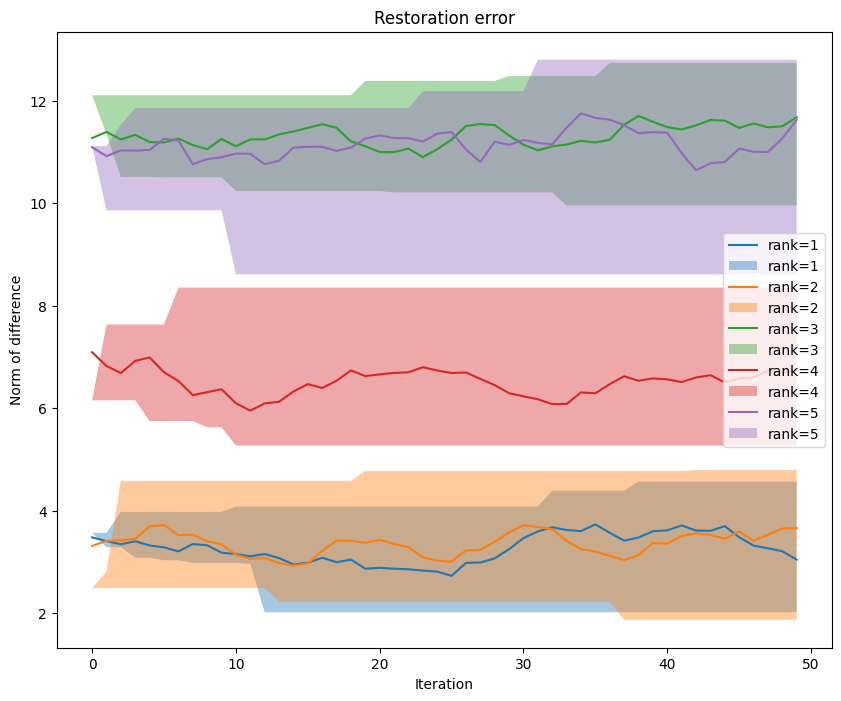

In [73]:
import pandas as pd

plt.figure(figsize=(10, 8))

print('Norm difference for best regression loss')

for rank in [1, 2, 3, 4, 5]:
    cov_diff_norm, losses, true_loss, best_loss_diff = res[rank]
    x = np.arange(len(cov_diff_norm))
    smooth_diff = pd.DataFrame(cov_diff_norm).rolling(7, center=True, min_periods=1).mean().values
    print(f'rank={rank}, norm diff:', best_loss_diff)
    # plt.plot(x, [best_loss_diff] * len(x), label=f'rank={rank}', marker='.', alpha=0.9)
    plt.plot(smooth_diff, label=f'rank={rank}')
    plt.fill_between(x, np.minimum.accumulate(cov_diff_norm),
                     np.maximum.accumulate(cov_diff_norm), alpha=0.4, label=f'rank={rank}')

plt.title('Restoration error')
plt.xlabel('Iteration')
plt.ylabel('Norm of difference')

plt.legend();

## Conclusion

During the Bayesian search for the original covariance matrix, the value of the norm difference fluctuates, but it is clear that the minimum error value decreases. It is also seen that when the rank approaches the maximum possible value ($r = 4, 5$), the change in the norm is the greatest. And it is more difficult to approximate the covariance matrix with a higher rank if you compare two groups: $r=1, 2$ and $r=3, 4, 5$